In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("dataset/T1.csv", parse_dates=["Date/Time"])
df.sort_values("Date/Time", inplace=True)

# Now convert to datetime with dayfirst=True (since your format is day month year)
df['Date/Time'] = pd.to_datetime(df['Date/Time'], dayfirst=True)

# --- Nonlinear transformations ---
df['WindSpeed_sq'] = df['Wind Speed (m/s)'] ** 2
df['WindSpeed_cu'] = df['Wind Speed (m/s)'] ** 3

# --- Cyclical encoding for wind direction ---
df['WindDir_sin'] = np.sin(2 * np.pi * df['Wind Direction (°)'] / 360)
df['WindDir_cos'] = np.cos(2 * np.pi * df['Wind Direction (°)'] / 360)

# --- Temporal features ---
df['HourOfDay'] = df['Date/Time'].dt.hour
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek

# --- Rolling statistics (1-hour window ≈ 6 points if 10-min interval) ---
df['RollingMean_WindSpeed'] = df['Wind Speed (m/s)'].rolling(window=6).mean()
df['RollingStd_WindSpeed'] = df['Wind Speed (m/s)'].rolling(window=6).std()

# --- Lag features ---
df['Lag1_WindSpeed'] = df['Wind Speed (m/s)'].shift(1)
df['Lag1_Power'] = df['LV ActivePower (kW)'].shift(1)

# --- Efficiency and curve deviation ---
df['Turbine_Efficiency'] = df['LV ActivePower (kW)'] / (df['Theoretical_Power_Curve (KWh)'] + 1e-3)
df['Power_Curve_Error'] = df['Theoretical_Power_Curve (KWh)'] - df['LV ActivePower (kW)']

# --- Difference features (turbulence) ---
df['WindSpeed_Diff'] = df['Wind Speed (m/s)'].diff()

# Drop initial NaN from rolling/lag features
df.dropna(inplace=True)


In [6]:
corr = df.corr(numeric_only=True)['LV ActivePower (kW)'].sort_values(ascending=False)
print(corr)

LV ActivePower (kW)              1.000000
Lag1_Power                       0.974953
Theoretical_Power_Curve (KWh)    0.949915
Wind Speed (m/s)                 0.912773
Lag1_WindSpeed                   0.894342
RollingMean_WindSpeed            0.887729
WindSpeed_sq                     0.858756
WindSpeed_cu                     0.744751
RollingStd_WindSpeed             0.124567
WindSpeed_Diff                   0.084570
DayOfWeek                        0.037923
HourOfDay                        0.036246
WindDir_sin                      0.035241
Power_Curve_Error               -0.030306
Turbine_Efficiency              -0.059147
Wind Direction (°)              -0.062604
WindDir_cos                     -0.174438
Name: LV ActivePower (kW), dtype: float64


In [7]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns=['LV ActivePower (kW)', 'Date/Time'])
y = df['LV ActivePower (kW)']

model = RandomForestRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=8)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())


Selected features: ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'WindSpeed_sq', 'WindSpeed_cu', 'Lag1_Power', 'Turbine_Efficiency', 'Power_Curve_Error', 'WindSpeed_Diff']


In [8]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5).fit(X, y)
importance = np.abs(lasso.coef_)
pd.Series(importance, index=X.columns).sort_values(ascending=False)


Theoretical_Power_Curve (KWh)    0.977523
Power_Curve_Error                0.968775
Lag1_Power                       0.020670
WindSpeed_cu                     0.000423
Wind Speed (m/s)                 0.000000
Wind Direction (°)               0.000000
WindSpeed_sq                     0.000000
WindDir_sin                      0.000000
WindDir_cos                      0.000000
HourOfDay                        0.000000
DayOfWeek                        0.000000
RollingMean_WindSpeed            0.000000
RollingStd_WindSpeed             0.000000
Lag1_WindSpeed                   0.000000
Turbine_Efficiency               0.000000
WindSpeed_Diff                   0.000000
dtype: float64

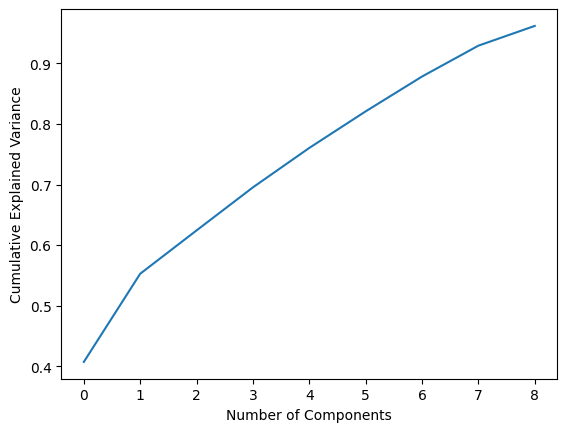

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


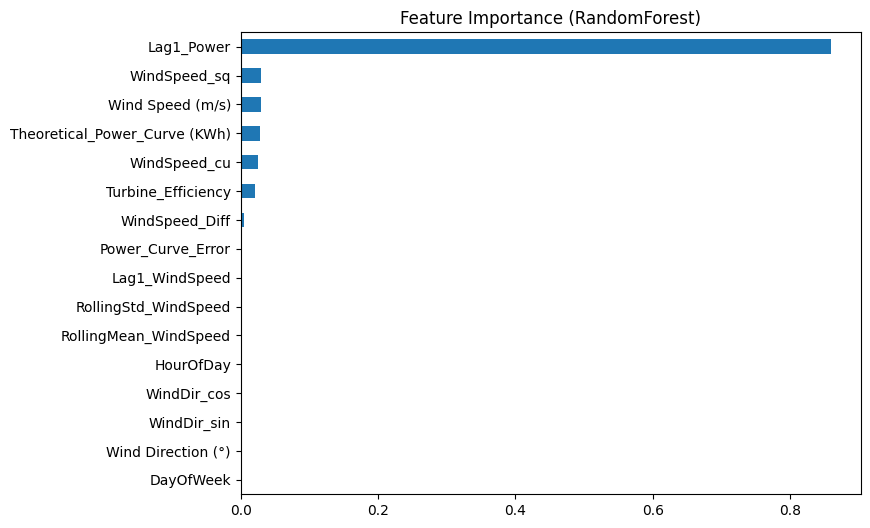

In [10]:
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

model = RandomForestRegressor(random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,6))
plt.title("Feature Importance (RandomForest)")
plt.show()


In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(model, X, y, n_repeats=10, random_state=42)
pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)


Turbine_Efficiency               0.295706
Lag1_Power                       0.032212
Theoretical_Power_Curve (KWh)    0.019241
WindSpeed_sq                     0.019189
WindSpeed_cu                     0.017778
Wind Speed (m/s)                 0.017405
Power_Curve_Error                0.001463
WindSpeed_Diff                   0.000956
Lag1_WindSpeed                   0.000106
RollingMean_WindSpeed            0.000061
RollingStd_WindSpeed             0.000021
HourOfDay                        0.000013
WindDir_sin                      0.000012
WindDir_cos                      0.000006
Wind Direction (°)               0.000004
DayOfWeek                        0.000002
dtype: float64

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Baseline: only original 3 features
base_features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train[base_features], y_train)
y_pred_base = model.predict(X_test[base_features])
base_rmse = root_mean_squared_error(y_test, y_pred_base)

# Extended: engineered features
model.fit(X_train, y_train)
y_pred_extended = model.predict(X_test)
extended_rmse = root_mean_squared_error(y_test, y_pred_extended)

print(f"Baseline RMSE: {base_rmse:.3f}")
print(f"With Engineered Features RMSE: {extended_rmse:.3f}")
print(f"Improvement: {((base_rmse - extended_rmse)/base_rmse)*100:.2f}%")

Baseline RMSE: 555.711
With Engineered Features RMSE: 42.680
Improvement: 92.32%
